# ⤵️Import Libraries 

In [47]:
import os
import re
import numpy as np
import pandas as pd
import datetime as dt

import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objs as go

import xlrd
import pickle as pkl

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import boxcox
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import zscore
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [2]:
col_pal = ['#8236CB', 
           '#EB2632']

# 📂Load Data

In [3]:
os.chdir('..')
curr_dir = (os.getcwd()).replace('\\', '/')
file_path = curr_dir + '/Dataset/Prcsd_Healthcare_dataset.xlsx'

In [4]:
drug_df = pd.read_excel(file_path)

In [5]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424 entries, 0 to 3423
Data columns (total 66 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   persistency_flag                                                    3424 non-null   object 
 1   region                                                              3424 non-null   object 
 2   age_bucket                                                          3424 non-null   object 
 3   ntm_specialist_flag                                                 3424 non-null   object 
 4   ntm_speciality_bucket                                               3424 non-null   object 
 5   gluco_record_prior_ntm                                              3424 non-null   object 
 6   gluco_record_during_rx                                              3424 non-null   object 
 7   dexa_freq_durin

# 📋Feature Selection

In [6]:
target = drug_df['persistency_flag']
drug_df.drop(['persistency_flag'], 
             axis=1, 
             inplace=True)

In [7]:
drug_df.columns

Index(['region', 'age_bucket', 'ntm_specialist_flag', 'ntm_speciality_bucket',
       'gluco_record_prior_ntm', 'gluco_record_during_rx',
       'dexa_freq_during_rx', 'dexa_during_rx', 'frag_frac_prior_ntm',
       'frag_frac_during_rx', 'risk_segment_prior_ntm',
       'tscore_bucket_prior_ntm', 'risk_segment_during_rx',
       'tscore_bucket_during_rx', 'change_t_score', 'change_risk_segment',
       'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx',
       'comorb_encounter_for_screening_for_malignant_neoplasms',
       'comorb_encounter_for_immunization',
       'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx',
       'comorb_vitamin_d_deficiency',
       'comorb_other_joint_disorder_not_elsewhere_classified',
       'comorb_encntr_for_oth_sp_exam_w_o_complaint_suspected_or_reprtd_dx',
       'comorb_long_term_current_drug_therapy', 'comorb_dorsalgia',
       'comorb_personal_history_of_other_diseases_and_conditions',
       'comorb_other_disorde

In [8]:
col_to_drp = ['ntm_specialist_flag', 'dexa_freq_during_rx', 'frag_frac_prior_ntm', 'frag_frac_during_rx', 
              'risk_segment_prior_ntm', 'tscore_bucket_prior_ntm', 'risk_segment_during_rx', 'tscore_bucket_during_rx', 
              'change_t_score', 'change_risk_segment', 'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx', ]

## Convert categorical to numerical 

In [9]:
X = drug_df.drop(['dexa_freq_during_rx', 'dexa_freq_during_rx_win', 'dexa_freq_during_rx_bc', 'count_of_risks_upd'], axis=1)

In [11]:
lbl_enc = LabelEncoder()
X = X.apply(lbl_enc.fit_transform)
X.head()

,region,age_bucket,ntm_specialist_flag,ntm_speciality_bucket,gluco_record_prior_ntm,gluco_record_during_rx,dexa_during_rx,frag_frac_prior_ntm,frag_frac_during_rx,risk_segment_prior_ntm,...,risk_chronic_liver_disease,risk_family_history_of_osteoporosis,risk_low_calcium_intake,risk_vitamin_d_insufficiency,risk_poor_health_frailty,risk_excessive_thinness,risk_hysterectomy_oophorectomy,risk_estrogen_deficiency,risk_immobilization,risk_recurring_falls
0,4,3,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,3,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
target = lbl_enc.fit_transform(target)
target

array([1, 0, 0, ..., 1, 0, 0])

In [13]:
# X.drop(['ntm_specialist_flag', 'frag_frac_prior_ntm', 'frag_frac_during_rx', 'risk_segment_prior_ntm', 
#         'tscore_bucket_prior_ntm', 'risk_segment_during_rx', 'tscore_bucket_during_rx', 'change_t_score', 'change_risk_segment', 
#         'adherent_flag', 'idn_indicator', 'injectable_experience_during_rx'], axis=1, inplace=True)

## RFECV 

> - **Random Forest Classifier**

In [14]:
rfc = RandomForestClassifier()
rfecv_rfc = RFECV(estimator=rfc, 
                  step=1, 
                  cv=StratifiedKFold(10), 
                  scoring='accuracy')
rfecv_rfc.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(), scoring='accuracy')

In [15]:
print('Optimal number of features: {}'.format(rfecv_rfc.n_features_))

Optimal number of features: 48


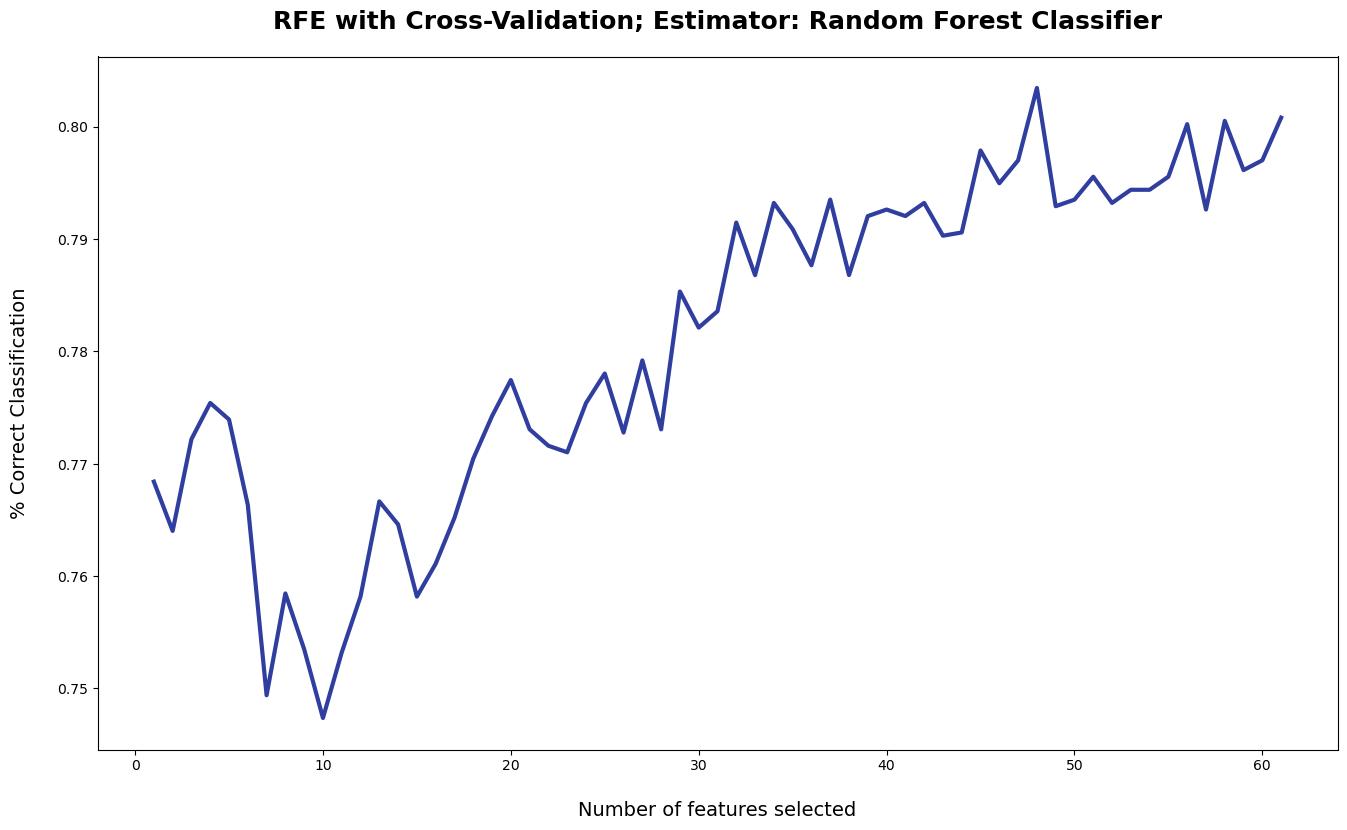

In [16]:
plt.figure(figsize=(16, 9))
plt.title('RFE with Cross-Validation; Estimator: Random Forest Classifier', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Number of features selected', 
           fontsize=14, 
           labelpad=20)
plt.ylabel('% Correct Classification', 
           fontsize=14, 
           labelpad=20)
plt.plot(range(1, len(rfecv_rfc.cv_results_['mean_test_score']) + 1), 
         rfecv_rfc.cv_results_['mean_test_score'], 
         color='#303F9F', 
         linewidth=3)

plt.show()

In [35]:
len(np.where(rfecv_rfc.support_ == True)[0])

48

In [56]:
X_rfc = X.drop(X.columns[np.where(rfecv_rfc.support_ == False)[0]], axis=1)

Text(0.5, 1.0, 'Feature Importance; Estimator: Random Forest Classifier')

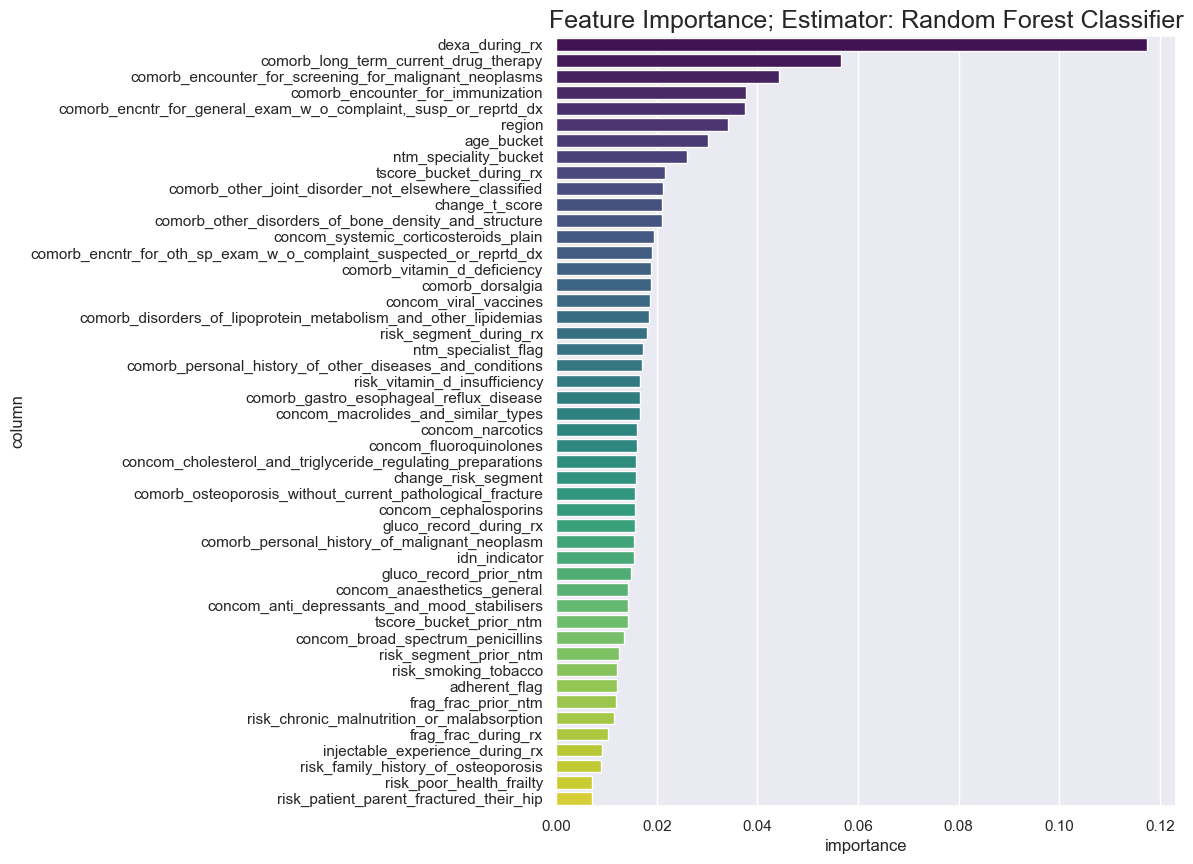

In [57]:
rfc_est_df = pd.DataFrame()

rfc_est_df['column'] = X_rfc.columns
rfc_est_df['importance'] = rfecv_rfc.estimator_.feature_importances_

rfc_est_df.sort_values(by='importance', 
                       ascending=False, 
                       inplace=True, 
                       ignore_index=True)

sns.set(rc = {'figure.figsize':(8,10)})
ax = sns.barplot(y='column', 
                 x='importance',
                 data=rfc_est_df,
                 palette='viridis')

ax.set_title('Feature Importance; Estimator: Random Forest Classifier', 
             fontsize=18)

Here, as observed from feature importance scores, there is almost steady decrease in importance score after *ntm_speciality_bucket*. Hence, we will select features upto this feature.

In [61]:
X_rfc = X_rfc[['dexa_during_rx', 'comorb_long_term_current_drug_therapy', 'comorb_encounter_for_immunization',
               'comorb_encounter_for_screening_for_malignant_neoplasms', 'region', 'age_bucket', 'ntm_speciality_bucket',
               'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx']]

> - **Logistic Regression**

In [19]:
lr = LogisticRegression()
rfecv_lr = RFECV(estimator=lr, 
                step=1, 
                cv=StratifiedKFold(10), 
                scoring='accuracy')
rfecv_lr.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

In [20]:
print('Optimal number of features: {}'.format(rfecv_lr.n_features_))

Optimal number of features: 49


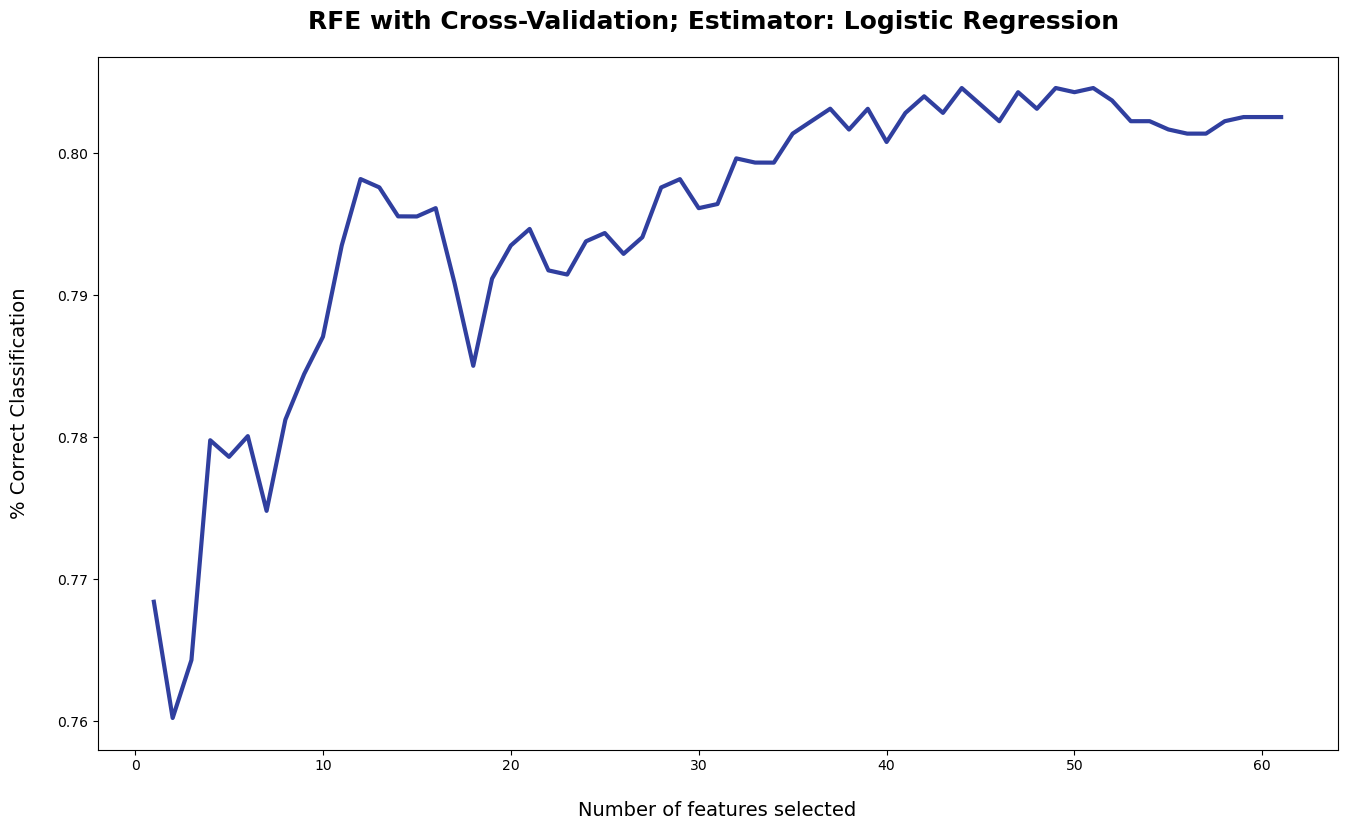

In [21]:
plt.figure(figsize=(16, 9))
plt.title('RFE with Cross-Validation; Estimator: Logistic Regression ', 
          fontsize=18, 
          fontweight='bold', 
          pad=20)
plt.xlabel('Number of features selected', 
           fontsize=14, 
           labelpad=20)
plt.ylabel('% Correct Classification', 
           fontsize=14, 
           labelpad=20)
plt.plot(range(1, len(rfecv_lr.cv_results_['mean_test_score']) + 1), 
         rfecv_lr.cv_results_['mean_test_score'], 
         color='#303F9F', 
         linewidth=3)

plt.show()

In [22]:
rfecv_lr.estimator_.coef_[0]

array([ 0.11743365,  0.36764215, -0.26416971, -0.55618711,  0.10973559,
        1.8653159 , -0.33638341,  0.21195267,  0.06134928, -0.12381263,
       -0.24616603, -0.15232253,  0.40086596,  0.28320351,  0.40462989,
        0.55832559,  0.41936246,  0.61003461,  0.76358878,  0.39995578,
        0.16478185,  0.97729624,  0.34567103,  0.22070025,  0.75380747,
       -0.30403209,  0.21697001,  0.40001218, -0.30886195,  0.52967438,
        0.31416908,  0.25320801,  0.28777188,  0.46093695,  0.20874307,
        0.92140653, -0.95006856, -0.43976097,  0.68921866, -0.1602611 ,
       -0.28631586,  0.12547568, -0.40088723, -0.95607064, -0.64872723,
       -0.34004688, -0.6396541 , -0.65566037, -0.97900984])

In [42]:
len(np.where(rfecv_lr.support_ == True)[0])

49

In [43]:
X_lr = X.drop(X.columns[np.where(rfecv_lr.support_ == False)[0]], axis=1)

Text(0.5, 1.0, 'Feature Importance; Estimator: Logistic Regression')

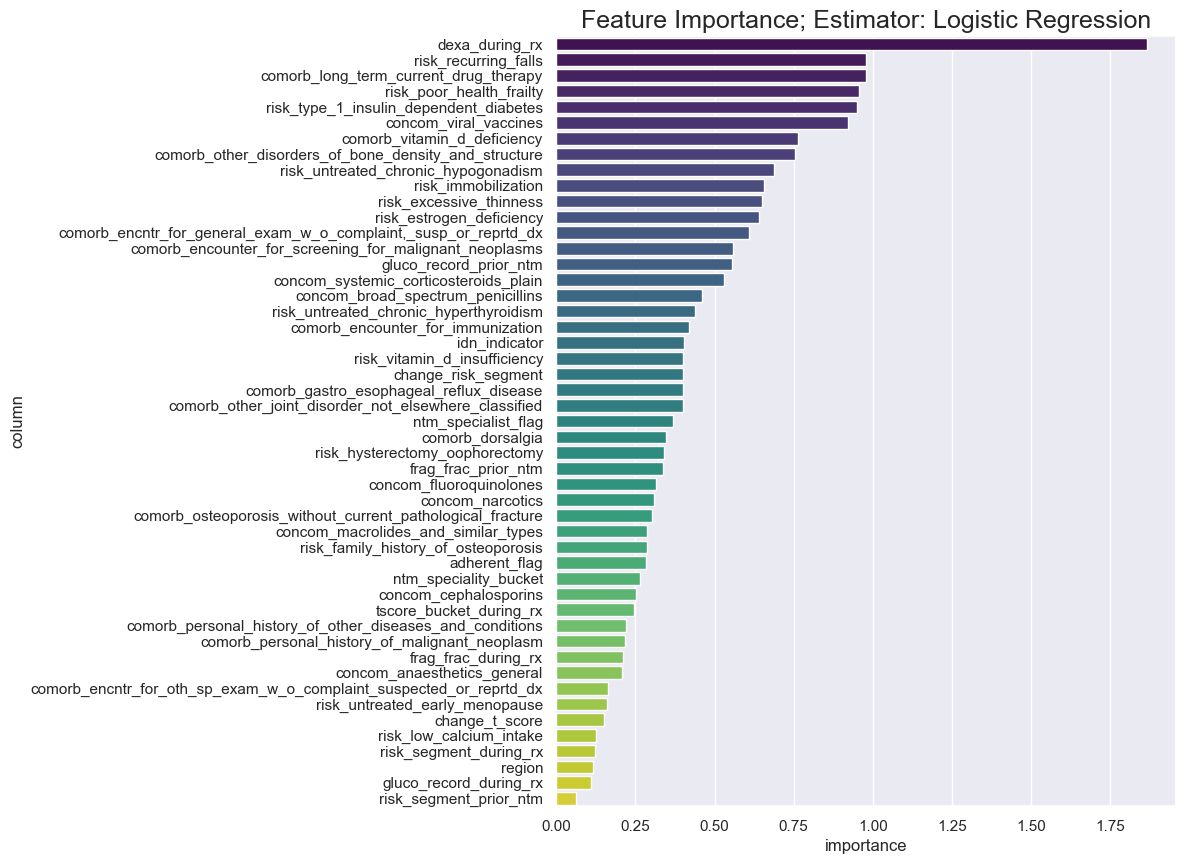

In [52]:
lr_est_df = pd.DataFrame()

lr_est_df['column'] = X_lr.columns
lr_est_df['importance'] = np.abs(rfecv_lr.estimator_.coef_[0])

lr_est_df.sort_values(by='importance', 
                      ascending=False, 
                      inplace=True, 
                      ignore_index=True)

sns.set(rc = {'figure.figsize':(8,10)})
ax = sns.barplot(y='column', 
                 x='importance',
                 data=lr_est_df,
                 palette='viridis')
ax.set_title('Feature Importance; Estimator: Logistic Regression', 
             fontsize=18)

In the above plot, when we observe the descrease in the importance score, a steady decrease can be seen after *concom_systemic_corticosteroids_plain* feature. Hence, we will select tall the features above this.

In [65]:
X_lr = X_lr[['comorb_long_term_current_drug_therapy', 'comorb_encounter_for_screening_for_malignant_neoplasms',
             'comorb_encntr_for_general_exam_w_o_complaint,_susp_or_reprtd_dx', 'risk_recurring_falls', 'dexa_during_rx',
             'risk_poor_health_frailty', 'risk_type_1_insulin_dependent_diabetes', 'concom_viral_vaccines', 
             'comorb_vitamin_d_deficiency', 'comorb_other_disorders_of_bone_density_and_structure', 
             'risk_untreated_chronic_hypogonadism', 'risk_immobilization', 'risk_excessive_thinness', 
             'risk_estrogen_deficiency', 'gluco_record_prior_ntm', 'concom_systemic_corticosteroids_plain']]

# 🏤Model Building/Selection

##  Features selected from RFECV: Random Forest

#### Split the Dataset 

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_rfc, target, test_size=0.2, random_state=42)

### Random Forest 